In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pdb import set_trace as st
from scipy.linalg import inv
from scipy import stats
from scipy.integrate import quad
from scipy.stats import multivariate_normal,rv_continuous,norm
from tqdm import tqdm
import torch
from typing import Callable
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

from utils.sampling import *
from utils.LGCP_Torch import * 
#from utils.LGCP import * 

Generate data points using custom function.
The code is optimized for data points between 0 and 1, but any other range can be normalized with a linear transformation:
x' = (x-x_min)/(x_max-x_min)


Fitted Parameters are a = 1.0083046117288896, b = 2.457111083578775


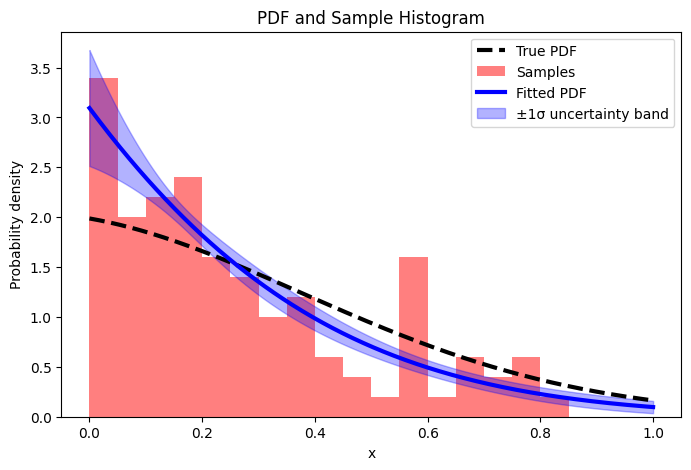

In [12]:

true_pdf = lambda x, a, b: np.exp(-a*x**2 - b*x) ### 
n_samples = 100
PARAMS = [2,0.5]
seed = 1

function_model = CustomPDFModel(true_pdf,PARAMS,n_samples,seed) 

samples = function_model.sample() # Samples n_samples from true_pdf
fitted_params = function_model.fit([1,1]) # Fit the samples to the true_pdf with some initial guess
print(f'Fitted Parameters are a = {fitted_params[0]}, b = {fitted_params[1]}')
ref_fit,ref_unc = function_model.plot(bins = 20) # Plot results

[Step 0] Marginal LL: 389.6477, Length: 0.9900, Var: 1.0101
[Step 10] Marginal LL: 390.6604, Length: 0.8993, Var: 1.1147
[Step 20] Marginal LL: 391.2157, Length: 0.8301, Var: 1.2264
[Step 30] Marginal LL: 391.5322, Length: 0.7836, Var: 1.3429
[Step 40] Marginal LL: 391.7004, Length: 0.7579, Var: 1.4564
[Step 50] Marginal LL: 391.8000, Length: 0.7488, Var: 1.5622
[Step 60] Marginal LL: 391.8751, Length: 0.7523, Var: 1.6596
[Step 70] Marginal LL: 391.9385, Length: 0.7642, Var: 1.7502
[Step 80] Marginal LL: 391.9939, Length: 0.7804, Var: 1.8354
[Step 90] Marginal LL: 392.0350, Length: 0.7960, Var: 1.9154
[Step 99] Marginal LL: 392.0602, Length: 0.8068, Var: 1.9832



Sample: 100%|█████████████████████| 1500/1500 [03:40,  6.81it/s, step size=9.12e-03, acc. prob=0.869]


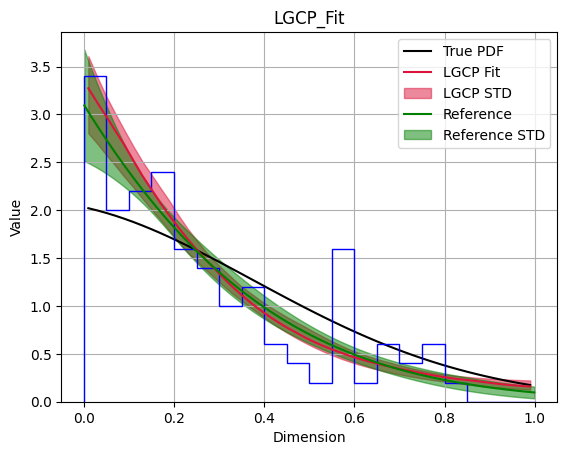

In [13]:
model = TorchModel(samples,optimizing_points = 50,length_scale = 1,var_scale = 1)
#model = Model(samples,optimizing_points = 50,length_scale = 1,var_scale = 1)
model.grad_optimize_hyperparameters(steps = 100,lr = 0.01)
model.grad_fit(lr = 0.01,epochs = 100)
model.plot(true_pdf(model.x,*PARAMS),ref_fit,ref_unc)#,samples = 20000)


In [ ]:
y = torch.exp(model.mean)
y /= np.trapz(y,model.x)
print(model.log_posterior(model.mean[None,:]))
print(model.log_posterior(torch.Tensor(model.median[None,:])))
plt.plot(model.x,y)
plt.plot(model.x,np.exp(model.median))
plt.hist(model.data,range = (0,1),histtype= 'step',bins = 20,density = True)